# Response function comparison
*Developed by Stijn Klop and Mark Bakker*

The purpose of this notebook is to compare several of the response functions available in Pastas.
The Gamma and Hantush response function are compared with the Four Parameter function. 

### Gamma Step Response
The Gamma step response function is defined as:
$$ s(t) = A  \dfrac{1}{\Gamma(n)} \int_{0}^{t} \tau^{n-1} \cdot e^{-\tau/a} d\tau $$

### Hantush Step Response
The Hantush step response function is defined as:
$$ s(t) = A  \dfrac{1}{\int_{0}^{\infty} \tau^{-1} \cdot e^{-\tau/a - b/\tau} d\tau} \int_{0}^{t} \tau^{-1} \cdot e^{-\tau/a - b/\tau} d\tau $$

### FourParam Step Response
Both these response functions are compared with the Four Parameter response function. The Four Parameter response function is defined as:
$$ s(t) = A  \dfrac{1}{\int_{0}^{\infty} \tau^{n-1} \cdot e^{-\tau/a - b/\tau} d\tau} \int_{0}^{t} \tau^{n-1} \cdot e^{-\tau/a - b/\tau} d\tau $$

The Hantush and Gamma response function are special cases of the Four Parameter function. In this notebook these response functions are compared. This is done using syntheticly generated groundwater observations.

First the required packages are imported and the data is loaded. The rainfall and evaporation data are imported from KNMI station De Bilt using Pastas. An extraction time series is imported using the Pandas package. For this example the time series are selected from the year 1980 until 2000.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammainc, gammaincinv
from scipy.integrate import quad
import pandas as pd
import pastas as ps
%matplotlib inline

In [2]:
rain = ps.read.read_knmi('data_notebook_5/etmgeg_260.txt', variables='RH').series
evap = ps.read.read_knmi('data_notebook_5/etmgeg_260.txt', variables='EV24').series
extraction = pd.read_csv('data_notebook_5/extraction.csv', 
                         index_col=0, parse_dates=True, dayfirst=True)['Extraction']

rain = rain['1980':'1999']
evap = evap['1980':'1999']
extraction = extraction['1980':'2000']

The Four Parameter response function is imported seperatly. Currently this response function is not yet implemented in the current version of Pastas.

In [5]:
# Define RfuncBase
class RfuncBase:
    _name = "RfuncBase"

    def __init__(self, up, meanstress, cutoff):
        self.up = up
        # Completely arbitrary number to prevent division by zero
        if 1e-8 > meanstress > 0:
            meanstress = 1e-8
        elif meanstress < 0 and up is True:
            meanstress = meanstress * -1
        self.meanstress = meanstress
        self.cutoff = cutoff
        self.tmax = 0

    def get_init_parameters(self, name):
        pass

    def get_tmax(self, p, cutoff=None):
        """Method to get the response time for a certain cutoff

        Parameters
        ----------
        p:  numpy.array
            numpy array with the parameters.
        cutoff: float, optional
            float between 0 and 1. Default is 0.99.

        Returns
        -------
        tmax: float
            Number of days when 99% of the response has passen, when the
            cutoff is chosen at 0.99.

        """
        pass

    def step(self, p, dt=1, cutoff=None):
        """Method to return the step funtion.

        Parameters
        ----------
        p: numpy.array
            numpy array with the parameters.
        dt: float
            timestep as a multiple of of day.
        cutoff: float, optional
            float between 0 and 1. Default is 0.99.

        Returns
        -------
        s: numpy.array
            Array with the step response.
        """
        pass

    def block(self, p, dt=1, cutoff=None):
        """Method to return the block funtion.

        Parameters
        ----------
        p: numpy.array
            numpy array with the parameters.
        dt: float
            timestep as a multiple of of day.
        cutoff: float, optional
            float between 0 and 1. Default is 0.99.

        Returns
        -------
        s: numpy.array
            Array with the block response.
        """
        s = self.step(p, dt, cutoff)
        return np.append(s[0], s[1:] - s[:-1])



In [13]:


class FourParam(RfuncBase):
    """Four Parameter response function with 4 parameters A, a, b, and n.

    Parameters
    ----------
    up: bool, optional
        indicates whether a positive stress will cause the head to go up
        (True, default) or down (False)
    meanstress: float
        mean value of the stress, used to set the initial value such that
        the final step times the mean stress equals 1
    cutoff: float
        percentage after which the step function is cut off. default=0.99.

    Notes
    -----

    .. math::
        step(t) = A / quad(t**n * np.exp(-t/a - b/t),0,np.inf) *
                      quad(t**n * np.exp(-t/a - b/t),0,t)

    """
    _name = "FourParam"

    def __init__(self, up=True, meanstress=1, cutoff=0.99):
        ps.rfunc.RfuncBase.__init__(self, up, meanstress, cutoff)
        self.nparam = 4
        self.quad = False

    def get_init_parameters(self, name):
        parameters = pd.DataFrame(
            columns=['initial', 'pmin', 'pmax', 'vary', 'name'])
        if self.up:
            parameters.loc[name + '_A'] = (1 / self.meanstress, 0,
                                           100 / self.meanstress, 1, name)
        else:
            parameters.loc[name + '_A'] = (-1 / self.meanstress,
                                           -100 / self.meanstress, 0, 1, name)
        parameters.loc[name + '_n'] = (1, -10, 10, 1, name)
        parameters.loc[name + '_a'] = (10, 0.01, 5000, 1, name)
        parameters.loc[name + '_b'] = (10, 0.01, 5000, 1, name)
        return parameters

    def function(self, t, p):
        return (t ** (p[1] - 1)) * np.exp(-t / p[2] - p[3] / t)

    def get_tmax(self, p, cutoff=None):
        if cutoff is None:
            cutoff = self.cutoff

        if self.quad:
            x = np.arange(1, 10000, 1)
            y = np.zeros_like(x)
            func = self.function(x, p)
            func_half = self.function(x[:-1] + 1 / 2, p)
            y[1:] = y[0] + np.cumsum(1 / 6 *
                                     (func[:-1] + 4 * func_half + func[1:]))
            y = y / quad(self.function, 0, np.inf, args=p)[0]
            return np.searchsorted(y, cutoff)

        else:
            t1 = -np.sqrt(3 / 5)
            t2 = 0
            t3 = np.sqrt(3 / 5)
            w1 = 5 / 9
            w2 = 8 / 9
            w3 = 5 / 9

            x = np.arange(1, 10000, 1)
            y = np.zeros_like(x)
            func = self.function(x, p)
            func_half = self.function(x[:-1] + 1 / 2, p)
            y[0] = 0.5 * (w1 * self.function(0.5 * t1 + 0.5, p) +
                          w2 * self.function(0.5 * t2 + 0.5, p) +
                          w3 * self.function(0.5 * t3 + 0.5, p))
            y[1:] = y[0] + np.cumsum(1 / 6 *
                                     (func[:-1] + 4 * func_half + func[1:]))
            y = y / quad(self.function, 0, np.inf, args=p)[0]
            return np.searchsorted(y, cutoff)

    def gain(self, p):
        return p[0]

    def step(self, p, dt=1, cutoff=0.99):

        if self.quad:
            if isinstance(dt, np.ndarray):
                t = dt
            else:
                self.tmax = max(self.get_tmax(p, cutoff), 3 * dt)
                t = np.arange(dt, self.tmax, dt)
            s = np.zeros_like(t)
            s[0] = quad(self.function, 0, dt, args=p)[0]
            for i in range(1, len(t)):
                s[i] = s[i - 1] + quad(self.function, t[i - 1], t[i], args=p)[0]
            s = s * (p[0] / (quad(self.function, 0, np.inf, args=p))[0])
            return s

        else:

            t1 = -np.sqrt(3 / 5)
            t2 = 0
            t3 = np.sqrt(3 / 5)
            w1 = 5 / 9
            w2 = 8 / 9
            w3 = 5 / 9

            if dt > 0.1:
                step = 0.1  # step size for numerical integration
                self.tmax = max(self.get_tmax(p, cutoff), 3 * step)
                t = np.arange(step, self.tmax, step)
                s = np.zeros_like(t)

                # for interval [0,dt] :
                s[0] = (step / 2) * \
                       (w1 * self.function((step / 2) * t1 + (step / 2), p) +
                        w2 * self.function((step / 2) * t2 + (step / 2), p) +
                        w3 * self.function((step / 2) * t3 + (step / 2), p))

                # for interval [dt,tmax]:
                func = self.function(t, p)
                func_half = self.function(t[:-1] + step / 2, p)
                s[1:] = s[0] + np.cumsum(step / 6 *
                                         (func[:-1] + 4 * func_half + func[1:]))
                s = s * (p[0] / quad(self.function, 0, np.inf, args=p)[0])
                return s[int(dt / step - 1)::int(dt / step)]
            else:
                if isinstance(dt, np.ndarray):
                    t = dt
                else:
                    self.tmax = max(self.get_tmax(p, cutoff), 3 * dt)
                    t = np.arange(dt, self.tmax, dt)
                s = np.zeros_like(t)

                # for interval [0,dt] Gaussian quadrate:
                s[0] = (dt / 2) * \
                       (w1 * self.function((dt / 2) * t1 + (dt / 2), p) +
                        w2 * self.function((dt / 2) * t2 + (dt / 2), p) +
                        w3 * self.function((dt / 2) * t3 + (dt / 2), p))

                # for interval [dt,tmax] Simpson integration:
                func = self.function(t, p)
                func_half = self.function(t[:-1] + dt / 2, p)
                s[1:] = s[0] + np.cumsum(dt / 6 *
                                         (func[:-1] + 4 * func_half + func[1:]))
                s = s * (p[0] / quad(self.function, 0, np.inf, args=p)[0])
                return s


class FourParamQuad(FourParam):
    """"Four Parameter response function with 4 parameters A, a, b, and n.

    Parameters
    ----------
    up: bool, optional
        indicates whether a positive stress will cause the head to go up
        (True, default) or down (False)
    meanstress: float
        mean value of the stress, used to set the initial value such that
        the final step times the mean stress equals 1
    cutoff: float
        percentage after which the step function is cut off. default=0.99.

    Notes
    -----
    This response function uses np.quad to integrate the Four Parameter response
    function, which requires more calculation time.
    This response function can be used for testing purposes.

    .. math::
        step(t) = A / quad(t**n * np.exp(-t/a - b/t),0,np.inf) *
                      quad(t**n * np.exp(-t/a - b/t),0,t)

    """
    _name = "FourParam"

    def __init__(self, up=True, meanstress=1, cutoff=0.99):
        FourParam.__init__(self, up, meanstress, cutoff)
        self.nparam = 4
        self.quad = True

### Defining required functions
Several function are defined to generate the synthetic groundwater observations. In this example two groundwater series are generated, one using a Gamma response function and one using a Hantush response function. 




In [14]:
def gamma_tmax(A, n, a, cutoff=0.99):
    return gammaincinv(n, cutoff) * a

def gamma_step(A, n, a, cutoff=0.99):
    tmax = gamma_tmax(A, n, a, cutoff)
    t = np.arange(0, tmax, 1)
    s = A * gammainc(n, t / a)
    return s

def gamma_block(A, n, a, cutoff=0.99):
    # returns the gamma block response starting at t=0 with intervals of delt = 1
    s = gamma_step(A, n, a, cutoff)
    return np.append(s[0], s[1:] - s[:-1])

def hantush_func(t, a, b):
    return (t ** -1) * np.exp(-(a / t) - (t / b))

def hantush_step(A, a, b, tmax=1000, cutoff=0.99):
    t = np.arange(0, tmax)
    f = np.zeros(tmax)
    for i in range(1,tmax):
        f[i] = quad(hantush_func, i-1, i, args=(a, b))[0]
    F = np.cumsum(f)
    return (A / quad(hantush_func, 0, np.inf, args=(a, b))[0]) * F

def hantush_block(A, a, b, tmax=1000, cutoff=0.99):
    s = hantush_step(A, a, b, tmax=tmax, cutoff=cutoff)
    return s[1:] - s[:-1]

## Comparing the Gamma and the Four Parameter response function

The first test is to compare the Gamma with the Four Parameter response function. Using the function defined above the Gamma block response function can be generated. The parameters for the block response `Atrue`, `ntrue` and `atrue` are defined together with the `dtrue` parameter. A synthetic groundwater head series is generated using the block response function and the rainfall data series.


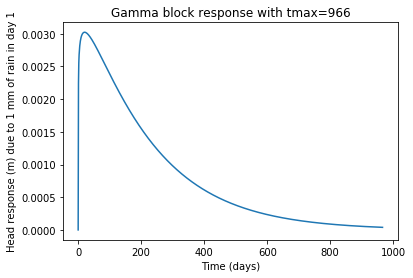

In [15]:
Atrue = 800
ntrue = 1.1
atrue = 200
dtrue = 20
h = gamma_block(Atrue, ntrue, atrue) * 0.001
tmax = gamma_tmax(Atrue, ntrue, atrue)
plt.plot(h)
plt.xlabel('Time (days)')
plt.ylabel('Head response (m) due to 1 mm of rain in day 1')
plt.title('Gamma block response with tmax=' + str(int(tmax)));

Text(0.5, 0, 'Time (years)')

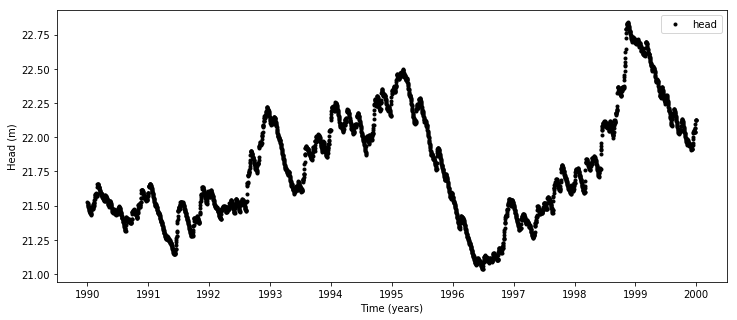

In [16]:
step = gamma_block(Atrue, ntrue, atrue)[1:]
lenstep = len(step)
h = dtrue * np.ones(len(rain) + lenstep)
for i in range(len(rain)):
    h[i:i + lenstep] += rain[i] * step
head = pd.DataFrame(index=rain.index, data=h[:len(rain)],)
head = head['1990':'1999']

plt.figure(figsize=(12,5))
plt.plot(head,'k.', label='head')
plt.legend(loc=0)
plt.ylabel('Head (m)')
plt.xlabel('Time (years)')

### Create Pastas model

The synthetic head series is used as input for the Pastas model. A stress model is created with the rainfall data series and the Gamma response function. The stress model is added to the Pastas model, and the model is solved.

INFO: Inferred frequency from time series 0: freq=D 
INFO: Inferred frequency from time series RH 260: freq=D 
Model Results 0               Fit Statistics
nfev     11                     EVP   100.00
nobs     3652                   R2      1.00
noise    0                      RMSE    0.00
tmin     1990-01-01 00:00:00    AIC      nan
tmax     1999-12-31 00:00:00    BIC      nan
freq     D                      ___         
warmup   3650                   ___         
solver   LeastSquares           ___         

Parameters (4 were optimized)
            optimal  stderr     initial vary
recharge_A    800.0  ±0.00%  224.669629    1
recharge_n      1.1  ±0.00%    1.000000    1
recharge_a    200.0  ±0.00%   10.000000    1
constant_d     20.0  ±0.00%   21.783161    1


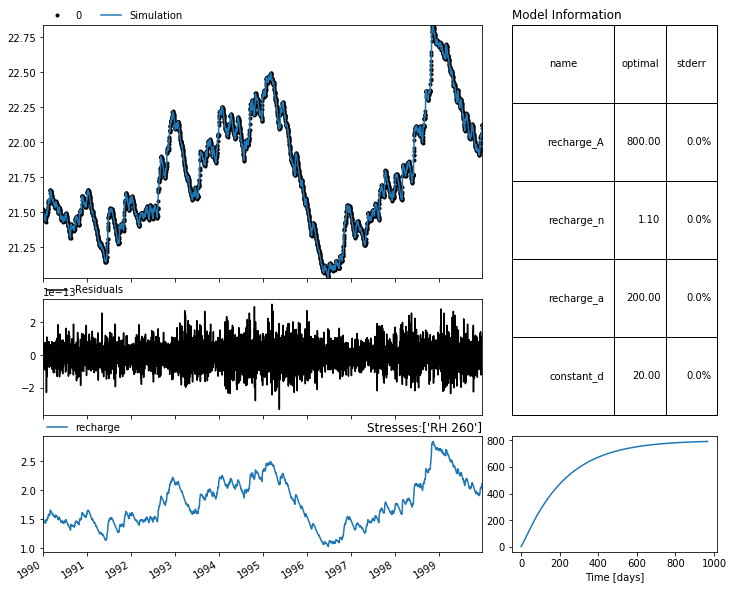

In [17]:
ml = ps.Model(head)
sm = ps.StressModel(rain, ps.Gamma, name='recharge', settings='prec')
ml.add_stressmodel(sm)
ml.solve(noise=False)
ml.plots.results()

The results of the Pastas simulation show that Pastas is able to simulate the synthetic groundwater head. The parameters calculated with Pastas are equal to the parameters used to generate the synthetic groundwater series; `Atrue`, `ntrue`, `atrue` and `dtrue`. 

### Create Pastas model using the Four Parameter response function
The next step is to simulate the synthetic head series using Pastas with the Four Parameter response function.
A new pastas model is created using the same head series as input. A stressmodel is created with the rainfall and the Four Parameter response function. The model is solved and the results are plotted.

INFO: Inferred frequency from time series 0: freq=D 
INFO: Inferred frequency from time series RH 260: freq=D 
Model Results 0                  Fit Statistics
nfev     45                     EVP      100.00
nobs     3652                   R2         1.00
noise    0                      RMSE       0.00
tmin     1990-01-01 00:00:00    AIC         nan
tmax     1999-12-31 00:00:00    BIC         nan
freq     D                      ___            
warmup   3650                   ___            
solver   LeastSquares           ___            

Parameters (5 were optimized)
               optimal  stderr     initial vary
recharge_A  799.596163  ±0.01%  224.669629    1
recharge_n    1.098068  ±0.02%    1.000000    1
recharge_a  199.622596  ±0.04%   10.000000    1
recharge_b    0.034566  ±4.13%   10.000000    1
constant_d   19.996177  ±0.00%   21.783161    1


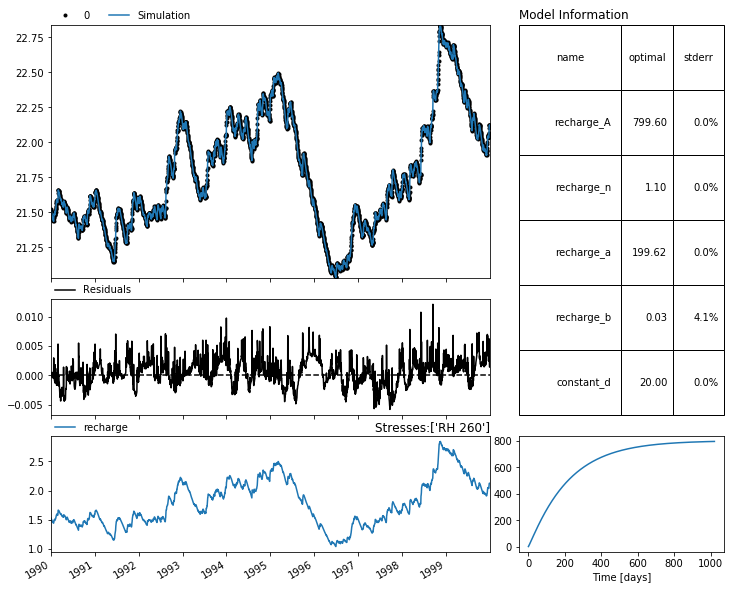

In [18]:
ml2 = ps.Model(head)
sm2 = ps.StressModel(rain, FourParam, name='recharge', settings='prec')
ml2.add_stressmodel(sm2)
ml2.solve(noise=False)
ml2.plots.results()

The results of the Pastas simulation show that the groundwater head series can be simulated using the Four Parameter resposne function. The parameters calculated using Pastas only slightly deviate from the parameters `Atrue`, `ntrue`, `atrue` and `dtrue` defined above. The parameter `recharge_b` is almost equal to 0 (meaning that the Four Parameter responce function is almost equal to the Gamma response function, as can be seen above). 



## Comparing the Hantush and Four Parameter response function

In the second example of this notebook the Four Parameter response function is compared to the Hantush response function. A Hantush block response is plotted using the parameters; `Atrue_hantush`, `atrue_hantush`, `btrue_hantush`. The parameter `btrue_hantush` is calculated using `rho` and `atrue_hantush` according to Veling & Maas (2010).

The Hantush block response is used together with the extraction data series to simulate the synthetic groundwater head.

In [ ]:
Atrue_hantush = -0.01 # Atrue is negative since a positive extraction results in a drop in groundwater head.
atrue_hantush = 100 # the parameter a is equal to cS in the hantush equation.
rho = 2
btrue_hantush = atrue_hantush * rho ** 2 / 4
dtrue_hantush = 20

h_hantush = hantush_block(Atrue_hantush, atrue_hantush, btrue_hantush) 
plt.plot(h_hantush)
plt.xlabel('Time (days)')
plt.ylabel('Head response (m) due to 1 m3 of extraction in day 1')
plt.title('Hantush block response with tmax=' + str(1000));

In [ ]:
step_hantush = hantush_block(Atrue_hantush, atrue_hantush, btrue_hantush)[1:]
lenstep = len(step_hantush)
h_hantush = dtrue * np.ones(len(extraction) + lenstep)
for i in range(len(extraction)):
    h_hantush[i:i + lenstep] += extraction[i] * step_hantush
head_hantush = pd.DataFrame(index=extraction.index, data=h_hantush[:len(extraction)],)
head_hantush = head_hantush['1990':'1999']

plt.figure(figsize=(12,5))
plt.plot(head_hantush,'k.', label='head')
plt.legend(loc=0)
plt.ylabel('Head (m)')
plt.xlabel('Time (years)')

### Create Pastas model
A Pastas model is created using the `head_hantush` series as input. A stress model is created with the Pastas Hantush response function and the extraction as input. The stress model is added to the Pastas model and the Pastas model is solved. 

In [ ]:
ml3 = ps.Model(head_hantush)
sm3 = ps.StressModel(extraction, ps.Hantush, name='extraction', settings='well', up=False)
ml3.add_stressmodel(sm3)
ml3.solve(noise=False)
ml3.plots.results()

The results of the Pastas simulation show that the observed head can be simulated using the Hantush response function. The parameters calibrated with Pastas are very close to the true parameters. 

### Create Pastas model using the Four Parameter response function
A new Pastas model is created. A stress model is created using the extraction data series and the Four Parameter function, `FourParam`, as input. The stress model is added to the Pastas model an the model is solved.

In [ ]:
ml4 = ps.Model(head_hantush)
sm4 = ps.StressModel(extraction, FourParam, name='extraction', settings='well', up=False)

ml4.add_stressmodel(sm4)
ml4.solve(noise=False)
ml4.plots.results()

The Pastas model is able to simulate the synthetic groundwater head. The parameters calibrated with Pastas with the Four Parameter function are close to the true parameters used to generate the groundwater head series. 

The deviations between the true and calibrated parameters are caused by the numerical aproximation of the Four Parameter response function used in Pastas. 

## References
---
Hantush, M. S., & Jacob, C. E. (1955). Non‐steady radial flow in an
    infinite leaky aquifer. Eos, Transactions American Geophysical Union,
    36(1), 95-100.

Veling, E. J. M., & Maas, C. (2010). Hantush well function
revisited. Journal of hydrology, 393(3), 381-388.

Von Asmuth, J. R., Maas, K., Bakker, M., & Petersen, J. (2008).
Modeling time series of ground water head fluctuations subjected to
multiple stresses. Ground Water, 46(1), 30-40.